In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import fenics
import dolfin
from fenics import *
from hmm.stokes import *
from util.basis_scaled import *
from dolfin import *
import matplotlib.pyplot as plt
from util.plot_tools import *
from util.random import smooth_random_loop_fourier_coef
from mshr import *
import boundary_solvers.geometry as geom
import boundary_solvers.gauss_grid_2d as grd

from mshr.cpp import CSGScaling, CSGTranslation

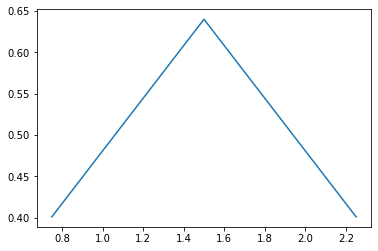

In [2]:
np.random.seed(1)

def param_to_poly(param, n_pts):
    t = np.linspace(0, 2*np.pi, n_pts+1)[:-1]
    xs, ys = param(t)
    try:
        pts = [Point(x, y) for x, y in zip(xs, ys)]
        return Polygon(pts)
    except:
        pts = [Point(x, y) for x, y in zip(xs[::-1], ys[::-1])]
        return Polygon(pts)


def param(t, c, K):
    ks = np.arange(-K, K)
    xy = (np.exp(1j * ks[None, :] * t[:, None]) @ c).real
    return xy[:, 0], xy[:, 1]


w, h  = 3, 1
blob_size = 0.6
pad = blob_size*1.2

N_blobs = 3
blobs = []
blob_x = np.linspace(0, w, N_blobs+2)[1:-1]
blob_y = (np.sin(blob_x/w * 5*np.pi) + 1)*0.5*(h-pad) + pad/2
plt.plot(blob_x, blob_y)
centers = [Point(x, y) for x, y in zip(blob_x, blob_y)]
sizes = np.ones((N_blobs)) * blob_size

domain = Rectangle(Point(0,0), Point(w, h))
for i in range(N_blobs):
    K = 7
    cs = smooth_random_loop_fourier_coef(K)
    poly = param_to_poly(lambda t: param(t, cs, K), 100)
    poly = CSGTranslation(CSGScaling(poly, sizes[i]/2), centers[i])
    domain = domain - poly

In [3]:
#data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_3/run_{70}.mat")
#data.geom(n_refine=1, n_corner_refine=1).plot(plt.gca(), npts=500)

# Parameters
w, h  = 3, 1
cx, cy, r = w/3, h/2, h/4
nx, ny = 20, 10

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(near(x[0], 0.) and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - w
        y[1] = x[1]


# Create mesh 
#channel = Rectangle(Point(0, 0), Point(w, h))
#inclusion = Circle(Point(cx, cy), r) + Circle(Point(cx*0.4, cy*1.2), r*0.6) + Circle(Point(cx*1.8, cy*0.7), r*0.8)
#domain = channel - inclusion
dom_mesh = generate_mesh(domain, resolution=100)


# Define the four boundaries + circle
inflow = 'near(x[0], 0)'
outflow = f'near(x[0],{w})'
floor = f'near(x[1],0)'
roof = f'near(x[1],{h})'
circle = f'on_boundary && !({inflow} || {outflow} || {floor} || {roof})'

# Define the function spaces
pb = PeriodicBoundary()
P2 = VectorElement(family='P', cell=triangle, degree=2)
P1 = FiniteElement(family='P', cell=triangle, degree=1)
P2P1 = P2 * P1
W = FunctionSpace(dom_mesh, P2P1, constrained_domain=pb)
U = W.sub(0)#extract_sub_space([0])

Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


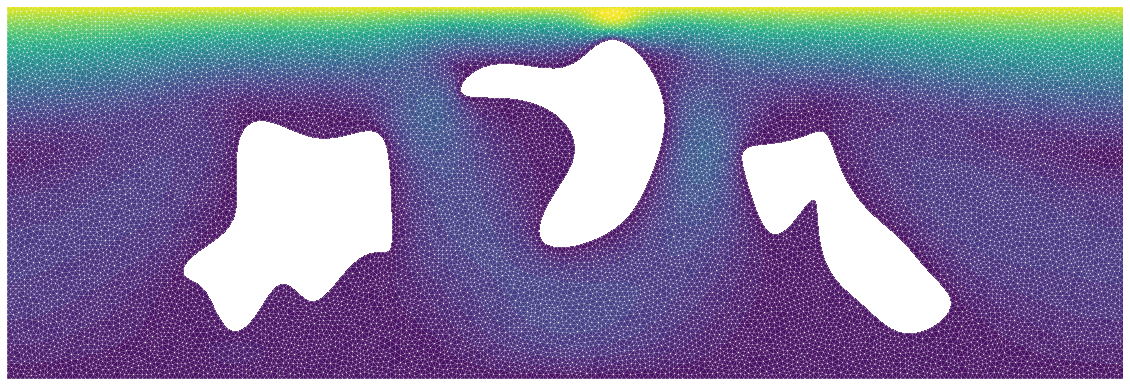

In [4]:
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)

# Forces
f = Constant((0,0))
g = Constant((0,0))
n = FacetNormal(dom_mesh)


# Boundary Conditions
bcu_roof = DirichletBC(U, Constant((1, 0)), roof)
bcu_floor = DirichletBC(U, Constant((0, 0)), floor)
bcu_circ = DirichletBC(U, Constant((0, 0)), circle)
bcu = [bcu_roof, bcu_floor, bcu_circ]


F = dot(grad(u)*v, n)*ds - p*dot(v,n)*ds - inner(grad(u),grad(v))*dx + p*div(v)*dx+ dot(u,grad(q))*dx - dot(f ,v)*dx - dot(u, n)*q*ds

a = lhs(F)
L = rhs(F)

# Compute Solution
w = Function(W)

#solve(A, w.vector(), b, 'bicgstab', 'hypre_amg')#, bcu)
solve(a==L, w, bcu)

# u,v,p define and project
u=project(w[0], W.sub(0).sub(0).collapse())
v=project(w[1], W.sub(0).sub(1).collapse())
p=project(w[2], W.sub(1).collapse())

plt.figure(figsize=(20,10))
plot((u**2 + v**2)**0.5)
plot(dom_mesh, color='white', linewidth=0.2)
remove_axes(plt.gca())
